# Real space Probability Density flow 

In this notebook, some initial probability density defined for the real bond random variable J are converted to probability densities for the dimensionless variable $\zeta$. We then flow these new pdf using solving the master equation for the dimensionless variable, and we can also recover the pdf for the real bound at  some new scale.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve


### Initial distributions available for J

In [29]:
# ---------------------------------------------------------
# 0. Classical initial probability distributions
# ---------------------------------------------------------

def exponential_P(x, lam=1.0):
    """Exponential distribution on [0,∞)."""
    return lam * np.exp(-lam * x)

def gamma_P(x, k=2, theta=1.0):
    """Gamma distribution."""
    from scipy.stats import gamma
    return gamma.pdf(x, a=k, scale=theta)

def gaussian_cut_P(x, mu=0, sigma=1):
    """Gaussian truncated to [0,∞)."""
    P = np.exp(-(x-mu)**2/(2*sigma**2))
    return np.where(x >= 0, P, 0)

def fermi_dirac_P(x, mu=1.0, T=0.2):
    """Finite-temperature Fermi-Dirac distribution on [0,∞) (numerically normalized)."""
    # Avoid overflow in exp((x - mu)/T)
    arg = (x - mu) / T
    P = 1.0 / (np.exp(arg) + 1.0)
    
    # Make sure it's zero for negative energies (if x-grid includes them)
    P = np.where(x >= 0, P, 0)
    
    # Normalize numerically
    norm = np.trapezoid(P, x)
    if norm > 0:
        P /= norm
    
    return P

### Some helper functions, useful to implement the evolution step, to plot the and to track the RG flow 

In [30]:
def shift_left(P, dx, dGamma):
    from scipy.interpolate import interp1d
    x = np.arange(len(P)) * dx
    f = interp1d(x - dGamma, P, bounds_error=False, fill_value=0)
    return f(x)

def real_power_law(x, Omega, Gamma):
    px = 1/(Omega*Gamma)* ((Omega/x)** (1-1/Gamma))
    return px / np.trapezoid(px, x)

def intelligent_xmax(x, P, p=0.99):
    dx = x[1] - x[0]
    cdf = np.cumsum(P) * dx
    cdf = np.clip(cdf, 0, 1)
    return np.interp(p, cdf, x)

def mean_P(x, P):
    return np.trapezoid(x * P, x)

def sigma_P(x, P):
    m = mean_P(x, P)
    return np.sqrt(np.trapezoid((x - m)**2 * P, x))

def exponential_pdf(x, Gamma):
    return np.exp(-x / Gamma) / Gamma

def L1_distance(P, P_ref, x):
    return np.trapezoid(np.abs(P - P_ref), x)

def zeta_to_J_pdf_stable(pZ, zeta_grid, Omega, N_J=2000, J_min=1e-10):
    # Create ascending log J grid
    J_max = Omega
    J_vals = np.linspace(J_min, J_max, N_J)

    # Corresponding zeta values
    zeta_for_J = np.log(Omega / J_vals)

    # Interpolate pZ onto zeta_for_J
    pZ_interp = np.interp(zeta_for_J, zeta_grid, pZ, left=0, right=0)

    # Apply Jacobian
    pJ = pZ_interp / J_vals

    # Normalize
    pJ /= np.trapezoid(pJ, J_vals)

    return J_vals, pJ

# # Convert current p_J to p_zeta
# def J_to_zeta_pdf(pJ, J_grid, Omega):
#     zeta_vals =np.log(Omega/J_grid)
#     # p_\zeta(\zeta) = p_J(J(\zeta)) * \zeta * \Omega*exp(-\zeta)
#     pZ = pJ * J_grid 
#     # Interpolate onto a uniform J grid (optional)
#     return zeta_vals, pZ / np.trapezoid(pZ, zeta_vals)



### RG Evolution step for dimensionless variable

In [31]:
# ---------------------------------------------------------
# 2. define evolution step
# ---------------------------------------------------------

def evolve(P, x, dGamma):
    dx = x[1] - x[0]
    N = len(x)

    # -----------------------------
    # Exact left shift by dGamma
    # -----------------------------

    P_shift = shift_left(P, dx, dGamma)

    # -----------------------------
    # Correct "delta" convolution
    #  -----------------------------

    P_conv = fftconvolve(P, P)[:N] * dx

    # Normalize P_conv
    integral_conv = np.trapezoid(P_conv, x)
    if integral_conv > 0:
        P_conv /= integral_conv

    # -----------------------------
    # Integral of P from 0 to dGamma
    # -----------------------------
    mask = x <= dGamma
    A0 = np.trapezoid(P[mask], x[mask])

    # -----------------------------
    # Updated pdf
    # -----------------------------
    P_new = P_shift + A0 * P_conv
    P_new = np.maximum(P_new, 0)

    P_new /= np.trapezoid(P_new, x)

    return P_new

## Setting up the input

Choose initial distribution for J among: "Gamma(k=2,θ=1)", "Gaussian cut (μ=0,σ=1)", "Exponential (λ=1)", "Fermi-Dirac (μ=1,T=0.1)".

Input Omega0 initial energy distribution.

Input either Omega_final or Gamma_final to stop the evolution and save the prob distr at that value. 

In [44]:
dGamma = 0.05

initial_distribution_name = "Gamma(k=2,θ=1)"

Omega0 = 4.71   #initial energy scale

Omega_final= 1.5




### Setting up the grid and the pdf for $\zeta$ and J

In [33]:
# ---------------------------------------------------------
# Set up J-grid, ζ-grid and boundaries
# ---------------------------------------------------------

N_J = 10000
J = np.linspace(1e-10, Omega0, N_J)   # avoid 0

zeta_max = np.log(Omega0/J[0])*10                # choose a value that takes into account how far the tail of final distribution goes
N = 50000 + 1                                    # +1 to get a round dx
zeta = np.linspace(0, zeta_max, N)
dzeta = zeta[1] - zeta[0]


ratio = dGamma/dzeta
if (ratio < 10):
    print("dGamma",dGamma,"must be >> dzeta", dzeta )

# ---------------------------------------------------------
# Initial PDFs in J space (they must be normalized)
# ---------------------------------------------------------

initial_distributions_J = {
    "Gamma(k=2,θ=1)": lambda J: gamma_P(J, k=2, theta=1.0),
    "Gaussian cut (μ=0,σ=1)": lambda J: gaussian_cut_P(J, mu=0, sigma=1),
    "Exponential (λ=1)": lambda J: exponential_P(J, lam=1.0),
    "Fermi-Dirac (μ=1,T=0.1)": lambda J: fermi_dirac_P(J, mu=1.0, T=0.1)
}

# ---------------------------------------------------------
# Convert initial PDFs from J to ζ
# ---------------------------------------------------------

initial_distributions_zeta = {}

for name, pdf_J in initial_distributions_J.items():

    # Evaluate p_J on the J grid
    pJ = pdf_J(J)
    # normalize pJ(J)
    pJ /= np.trapezoid(pJ, J)

    # Convert J -> ζ
    # J(ζ) = Ω e^{-ζ}
    J_of_zeta = Omega0 * np.exp(-zeta)

    # p_ζ(ζ) = p_J(J(ζ)) * |dJ/dζ| = p_J(J(ζ)) * J(ζ)
    pJ_interp = np.interp(J_of_zeta, J, pJ, left=0, right=0)
    pZ = pJ_interp * J_of_zeta

    # Normalize on ζ grid
    pZ /= np.trapezoid(pZ, zeta)

    # Store
    initial_distributions_zeta[name] = pZ



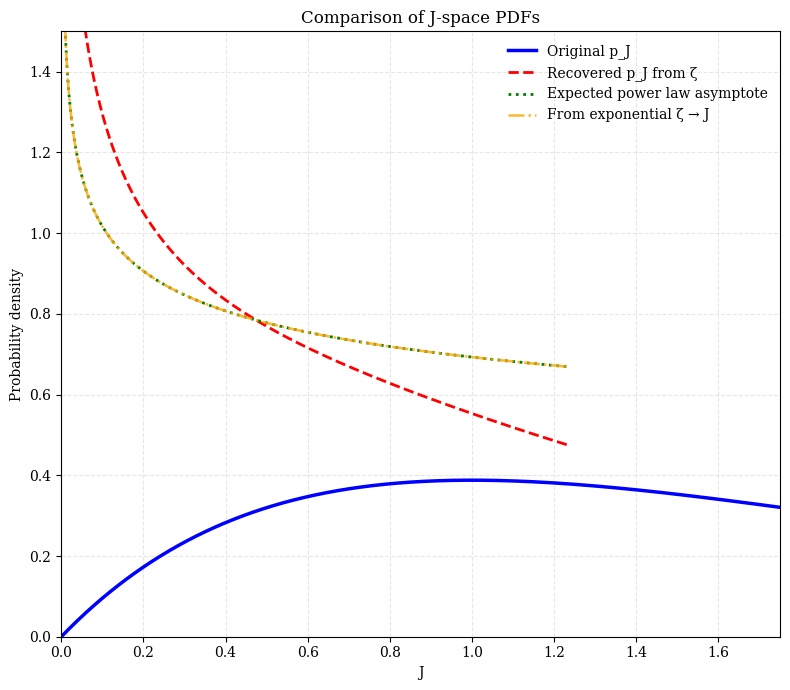

NameError: name 'pJ_recovered' is not defined

In [34]:
# Original PDF in J-space
pJ_orig = initial_distributions_J[initial_distribution_name](J)
pJ_orig /= np.trapezoid(pJ_orig, J)  # normalize

# Converted to ζ-space
pZ = initial_distributions_zeta[initial_distribution_name]

Gamma_final = np.log(Omega0/Omega_final)
# print(Gamma_final)
n_steps = np.rint(Gamma_final/dGamma).astype(int)  # number of RG steps
# print(n_steps)

Omega = Omega0
Gamma = 0

for i in range(n_steps):
    pZ = evolve(pZ, zeta, dGamma)
    Omega = Omega - Omega * dGamma
    Gamma = Gamma + dGamma

pZ_final = pZ

J_vals, pJ_final = zeta_to_J_pdf_stable(pZ, zeta, Omega, N_J=2000)

J_vals, pJ_exp = zeta_to_J_pdf_stable(exponential_pdf(zeta, Gamma), zeta, Omega)

# print("min J:", J_vals[0], "max J:", J_vals[-1])
# print("min pJ:", pJ_final.min(), "max pJ:", pJ_recovered.max())
# print("Integral:", np.trapezoid(pJ_recovered, J_vals))

plt.figure(figsize=(8,7))

plt.plot(J, pJ_orig,
         label="Original p_J",
         linewidth=2.5,
         color="blue")

plt.plot(J_vals, pJ_final,
         label="Recovered p_J from ζ",
         linewidth=2,
         linestyle="--",
         color="red")

plt.plot(J_vals, real_power_law(J_vals, Omega, Gamma),
         label="Expected power law asymptote",
         linewidth=2,
         linestyle=":",
         color="green")

plt.plot(J_vals, pJ_exp,
         label="From exponential ζ → J",
         linewidth=1.8,
         linestyle="-.",
         color="orange",
         alpha=0.8)

# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("J")
plt.ylabel("Probability density")
plt.title("Comparison of J-space PDFs")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.xlim(0,1.75)
plt.ylim(0,1.5)
plt.legend()
plt.tight_layout()
plt.show()


# Optional: check numerical difference
diff = np.trapezoid(np.abs(np.interp(J, J_vals, pJ_recovered) - pJ_orig), J)
print("L1 difference between original and recovered p_J:", diff)

# Prob density for J and zeta are stored in:
# zeta, pZ_final
# J_vals, pJ_final


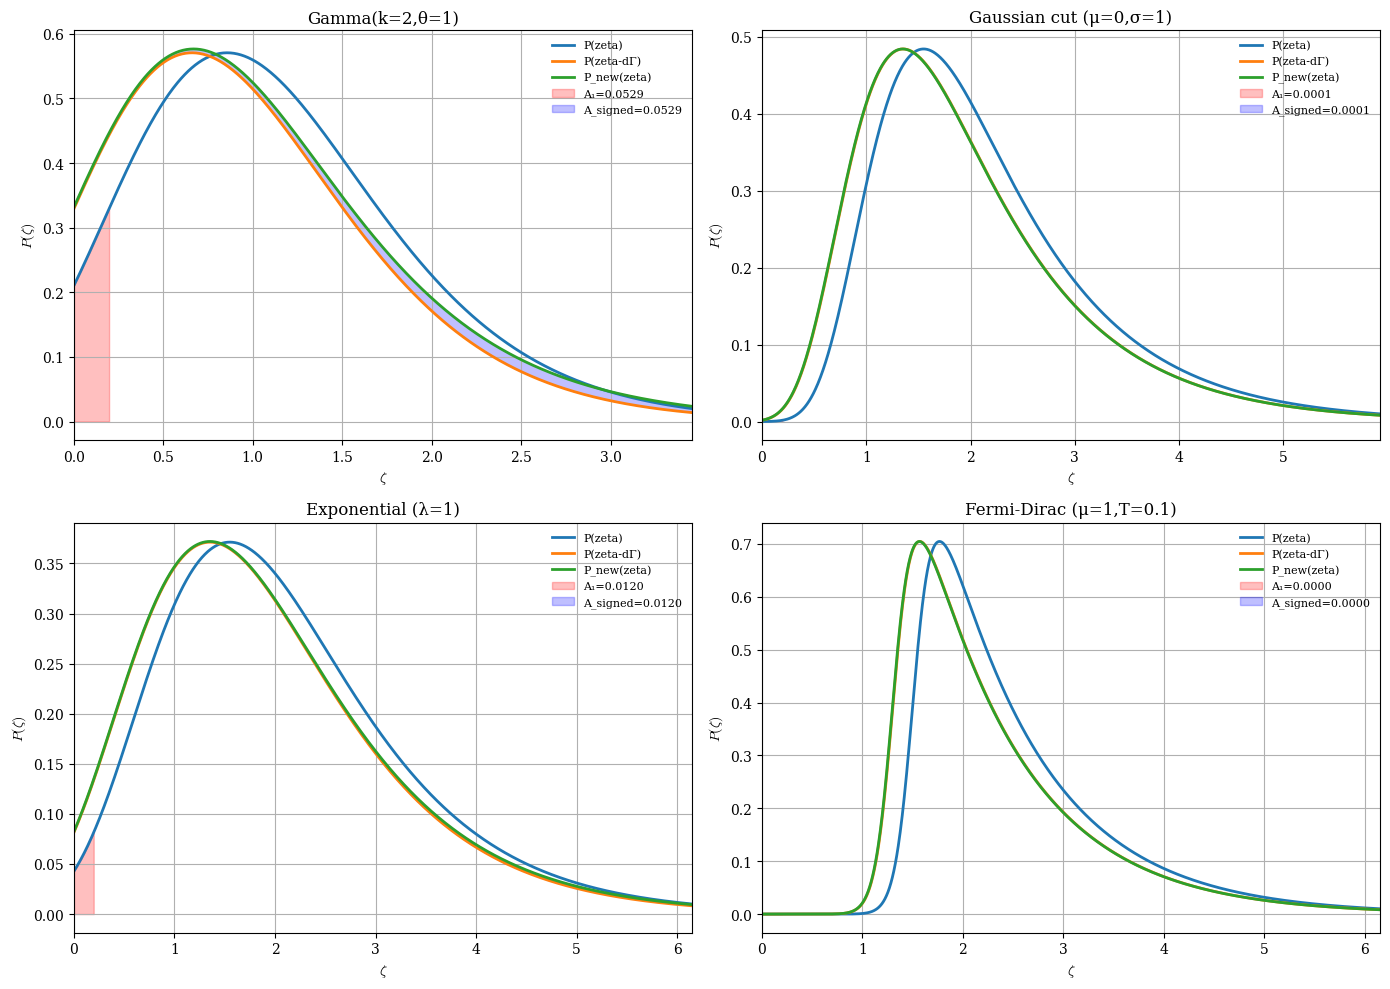

In [35]:
# ============================================
# Plot all initial distributions in ζ-space
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, P_orig) in zip(axes, initial_distributions_zeta.items()):
    # Copy array to avoid modifying original
    P = P_orig.copy()
    
    # Ensure normalization
    P /= np.trapezoid(P, zeta)

    # Evolve once
    P_new = evolve(P, zeta, dGamma)

    # Build shifted P(zeta - dGamma)
    P_shift = np.zeros_like(P)
    shift_idx = int(dGamma / dzeta)
    if shift_idx < len(P):
        P_shift[:-shift_idx] = P[shift_idx:]
    else:
        # If shift is larger than array, leave P_shift as zeros
        shift_idx = len(P) - 1

    # Compute intelligent zeta-limit for plotting
    zeta_max_plot = intelligent_xmax(zeta, P, p=0.99)

    # ------------------------------
    # Plot curves
    # ------------------------------
    ax.plot(zeta, P, label="P(zeta)", linewidth=2)
    ax.plot(zeta, P_shift, label=f"P(zeta-dΓ)", linewidth=2)
    ax.plot(zeta, P_new, label="P_new(zeta)", linewidth=2)

    # ------------------------------
    # Region 1: area under P(zeta) in [0, dGamma]
    # ------------------------------
    mask_region1 = (zeta >= 0) & (zeta <= dGamma)
    area1 = np.trapezoid(P[mask_region1], zeta[mask_region1])
    ax.fill_between(
        zeta[mask_region1], P[mask_region1],
        color="red", alpha=0.25,
        label=f"A₁={area1:.4f}"
    )

    # ------------------------------
    # Region 2: signed difference P_new - P_shift
    # ------------------------------
    diff = P_new - P_shift
    area_signed = np.trapezoid(diff, zeta)

    mask_pos = diff > 0
    mask_neg = diff < 0

    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_pos,
        color="blue", alpha=0.25,
        label=f"A_signed={area_signed:.4f}"
    )
    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_neg,
        color="blue", alpha=0.25
    )

    # ------------------------------
    # Formatting
    # ------------------------------
    ax.set_xlim(0, zeta_max_plot)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel(r"$P(\zeta)$")
    ax.set_title(name)
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


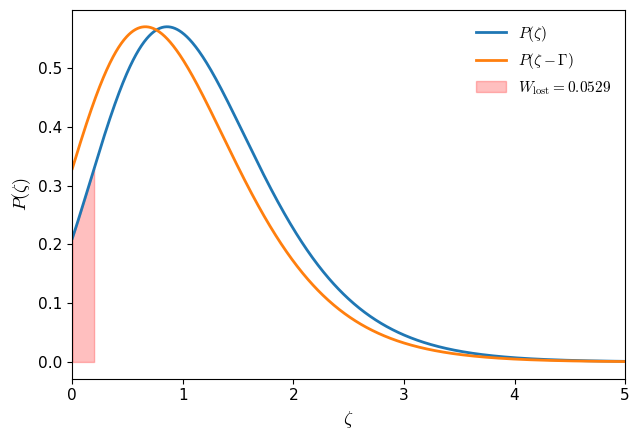

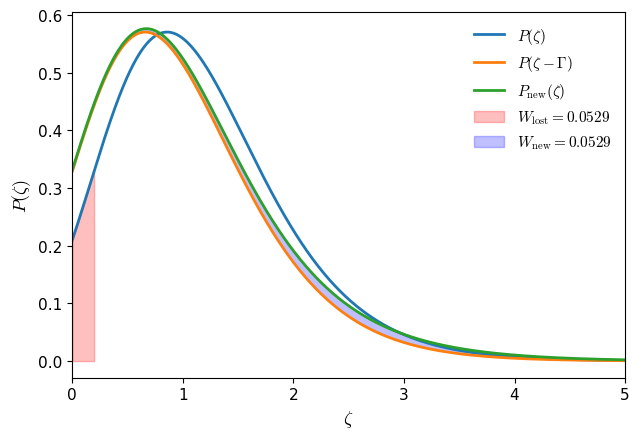

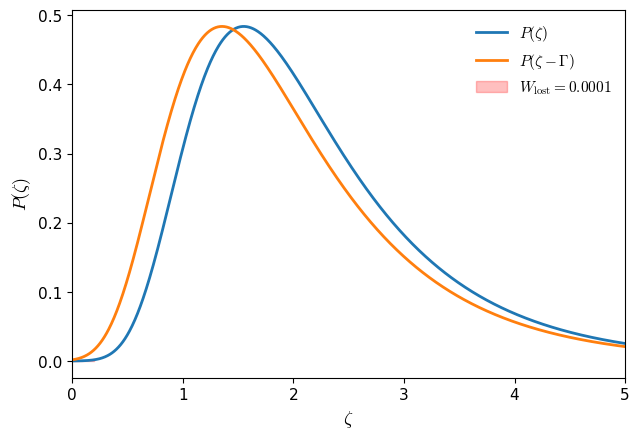

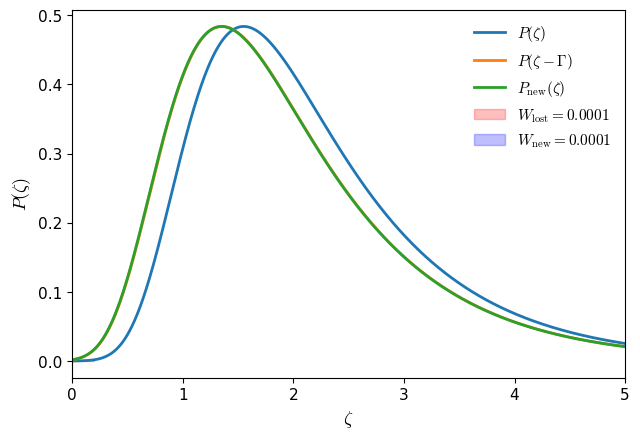

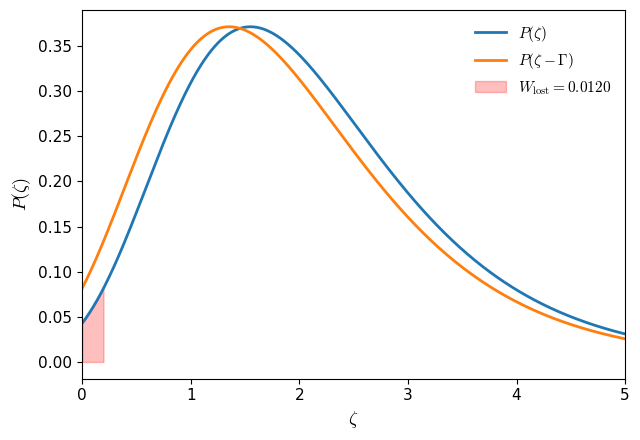

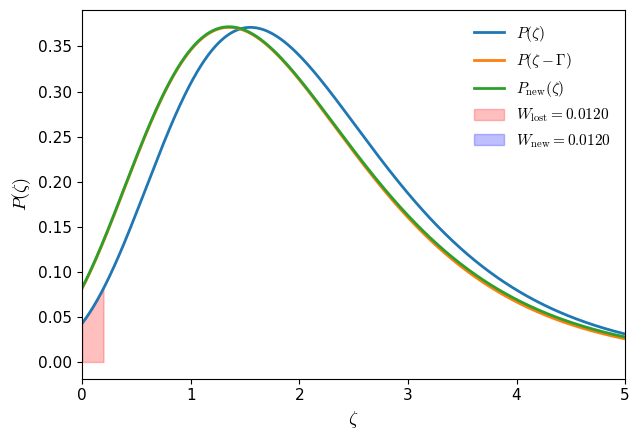

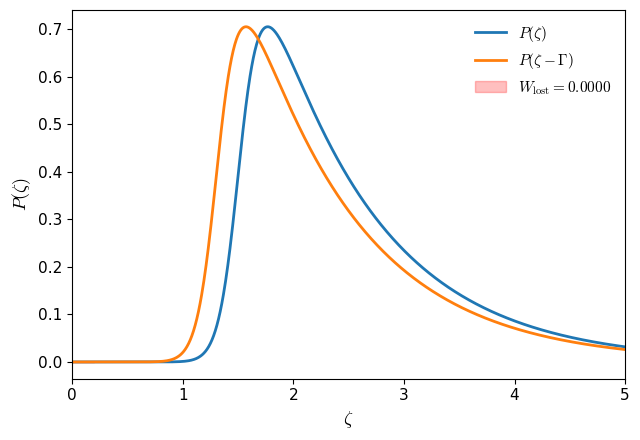

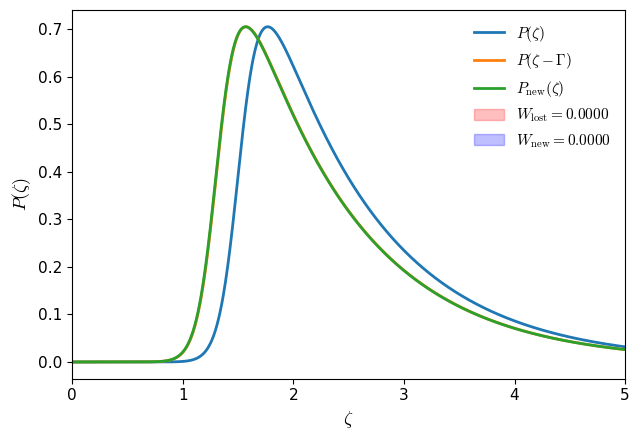

In [36]:
# ============================================
# Presentation figure cell
# ζ-space plots: two figures per distribution
# (math labels + plain numeric ticks)
# ============================================

import matplotlib as mpl
mpl.rcParams["text.usetex"] = False

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif",
    "legend.frameon": False
})

for name, P_orig in initial_distributions_zeta.items():

    # -------------------------------------------------
    # Prepare distribution
    # -------------------------------------------------
    P = P_orig.copy()
    P /= np.trapezoid(P, zeta)

    P_new = evolve(P, zeta, dGamma)

    P_shift = np.zeros_like(P)
    shift_idx = int(dGamma / dzeta)
    if shift_idx < len(P):
        P_shift[:-shift_idx] = P[shift_idx:]

    zeta_max_plot = 5

    mask_r = (zeta >= 0) & (zeta <= dGamma)
    area1 = np.trapezoid(P[mask_r], zeta[mask_r])

    diff = P_new - P_shift
    area_signed = np.trapezoid(diff, zeta)

    # =================================================
    # Figure 1: old + shifted + red area
    # =================================================
    fig1, ax1 = plt.subplots(figsize=(6.5, 4.5))

    ax1.plot(zeta, P, linewidth=2, label=r"$P(\zeta)$")
    ax1.plot(zeta, P_shift, linewidth=2, label=r"$P(\zeta-\Gamma)$")

    ax1.fill_between(
        zeta[mask_r],
        P[mask_r],
        color="red",
        alpha=0.25,
        label=rf"$W_{{\mathrm{{lost}}}} = {area1:.4f}$"
    )

    ax1.set_xlim(0, zeta_max_plot)
    ax1.set_xlabel(r"$\zeta$", fontsize=13)
    ax1.set_ylabel(r"$P(\zeta)$", fontsize=13)
    # ax1.set_title(name)
    ax1.legend(loc="upper right", fontsize=11)
    ax1.grid(False)

    ax1.tick_params(axis="both", labelsize=11)
    for lbl in ax1.get_xticklabels() + ax1.get_yticklabels():
        lbl.set_fontfamily("sans-serif")

    plt.tight_layout()
    plt.savefig("Gamma_flow_step_1.pdf", bbox_inches="tight")

    # =================================================
    # Figure 2: full plot with red + blue areas
    # =================================================
    fig2, ax2 = plt.subplots(figsize=(6.5, 4.5))

    ax2.plot(zeta, P, linewidth=2, label=r"$P(\zeta)$")
    ax2.plot(zeta, P_shift, linewidth=2, label=r"$P(\zeta-\Gamma)$")
    ax2.plot(zeta, P_new, linewidth=2, label=r"$P_{\mathrm{new}}(\zeta)$")

    ax2.fill_between(
        zeta[mask_r],
        P[mask_r],
        color="red",
        alpha=0.25,
        label=rf"$W_{{\mathrm{{lost}}}} = {area1:.4f}$"
    )

    ax2.fill_between(
        zeta,
        P_shift,
        P_new,
        where=diff > 0,
        color="blue",
        alpha=0.25,
        label=rf"$W_{{\mathrm{{new}}}} = {area_signed:.4f}$"
    )

    ax2.fill_between(
        zeta,
        P_shift,
        P_new,
        where=diff < 0,
        color="blue",
        alpha=0.25
    )

    ax2.set_xlim(0, zeta_max_plot)
    ax2.set_xlabel(r"$\zeta$", fontsize=13)
    ax2.set_ylabel(r"$P(\zeta)$", fontsize=13)
    # ax2.set_title(name)
    ax2.legend(loc="upper right", fontsize=11)
    ax2.grid(False)

    ax2.tick_params(axis="both", labelsize=11)
    for lbl in ax2.get_xticklabels() + ax2.get_yticklabels():
        lbl.set_fontfamily("sans-serif")

    plt.tight_layout()
    plt.savefig("Gamma_flow_step_2.pdf", bbox_inches="tight")


1.144222799920162
6


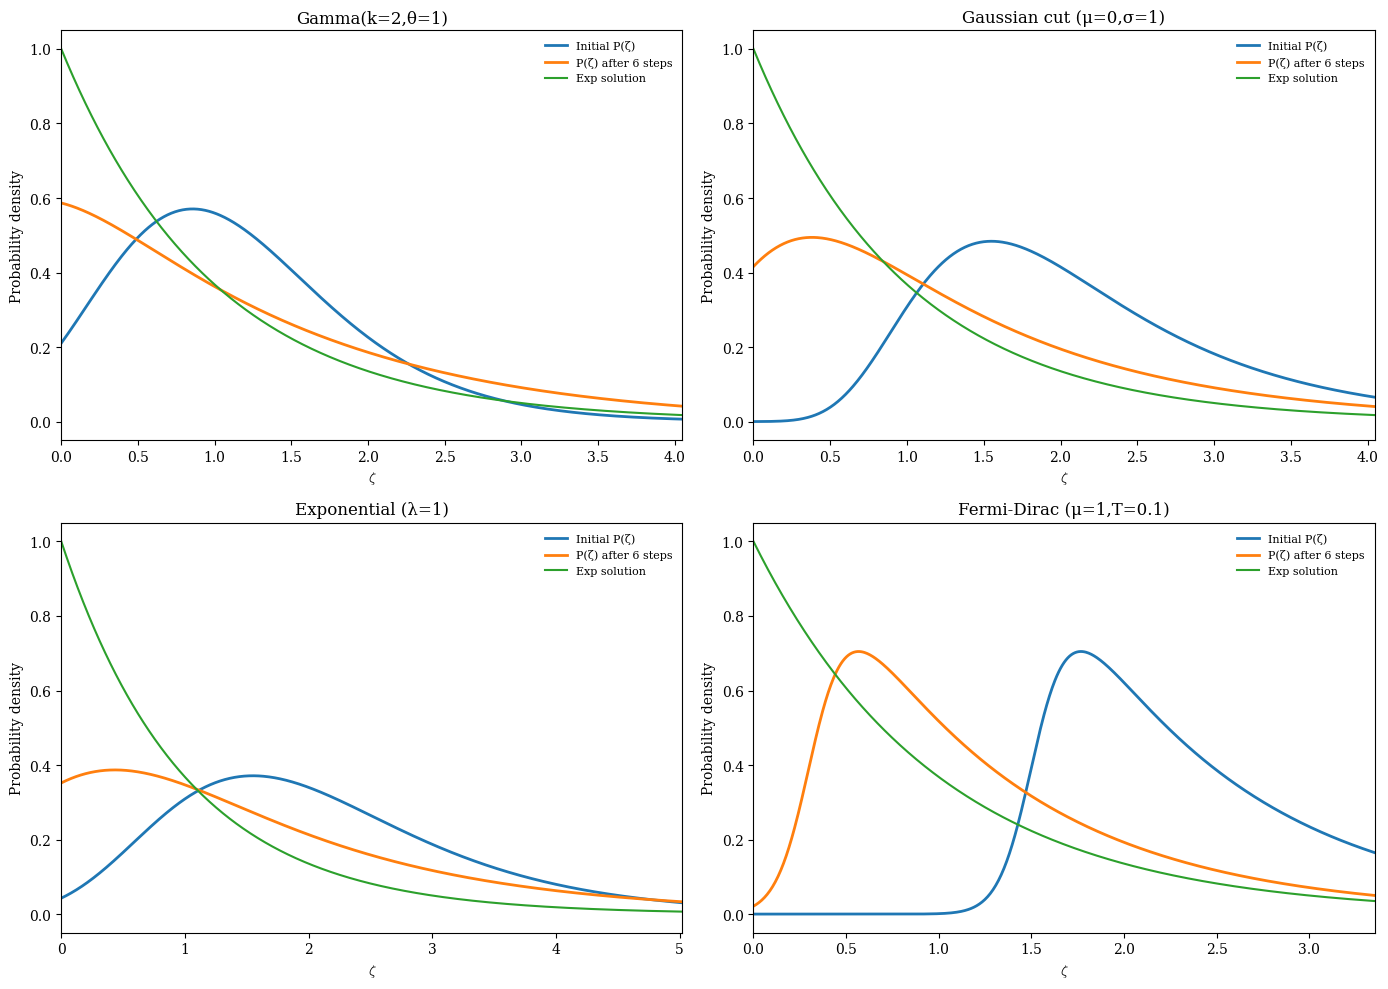

In [37]:
# ============================================
#  Evolution for all 4 initial distributions
# ============================================

Gamma_final = np.log(Omega0/Omega_final)
print(Gamma_final)
n_steps = np.rint(Gamma_final/dGamma).astype(int)  # number of RG steps
print(n_steps)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# To store diagnostics for all distributions
results = {}

for ax, (name, P_init_orig) in zip(axes, initial_distributions_zeta.items()):
    
    # ---------------------------------------------------------
    # Build initial distribution (copy to avoid modifying original)
    # ---------------------------------------------------------
    P_init = P_init_orig.copy()
    P_init /= np.trapezoid(P_init, zeta)  # normalize on zeta grid

    # ---------------------------------------------------------
    # Initialize storage lists
    # ---------------------------------------------------------
    Gammas = []
    Means = []
    Sigmas = []
    Errors = []

    # ---------------------------------------------------------
    # Evolve for n_steps
    # ---------------------------------------------------------
    P_current = P_init.copy()
    for step in range(n_steps):

        Gamma = (step) * dGamma
        Gammas.append(Gamma)

        # diagnostics BEFORE evolution step
        m = mean_P(zeta, P_current)
        s = sigma_P(zeta, P_current)
        Means.append(m)
        Sigmas.append(s)

        # exponential reference PDF
        P_ref = exponential_pdf(zeta, Gamma if Gamma > 0 else dGamma)
        err = L1_distance(P_current, P_ref, zeta)
        Errors.append(err)

        # evolve one RG step
        P_current = evolve(P_current, zeta, dGamma)

    # save diagnostics
    results[name] = {
        "Gamma": np.array(Gammas),
        "Mean": np.array(Means),
        "Sigma": np.array(Sigmas),
        "Error": np.array(Errors)
    }

    # ---------------------------------------------------------
    # Intelligent plot cutoff (based on final PDF)
    # ---------------------------------------------------------
    zeta_max_plot = intelligent_xmax(zeta, P_current, p=0.95)

    # ---------------------------------------------------------
    # Plot
    # ---------------------------------------------------------
    ax.plot(zeta, P_init, label="Initial P(ζ)", linewidth=2)
    ax.plot(zeta, P_current, label=f"P(ζ) after {n_steps} steps", linewidth=2)
    ax.plot(zeta, exponential_pdf(zeta, Gamma), label="Exp solution")

    ax.set_xlim(0, zeta_max_plot)
    ax.set_title(name)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel("Probability density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


<>:81: SyntaxWarning: invalid escape sequence '\G'
<>:81: SyntaxWarning: invalid escape sequence '\G'
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/2107772161.py:81: SyntaxWarning: invalid escape sequence '\G'
  label="$P^{*}_{\Gamma}(\zeta) =1/\Gamma e^{1/\Gamma}$"


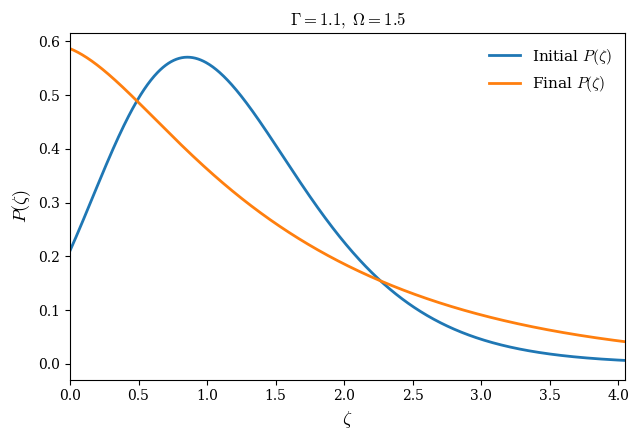

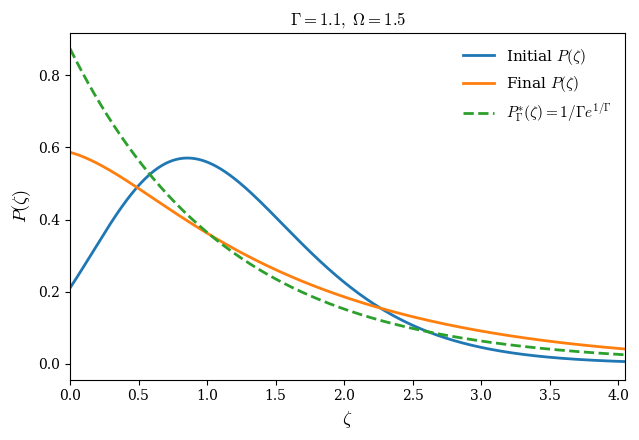

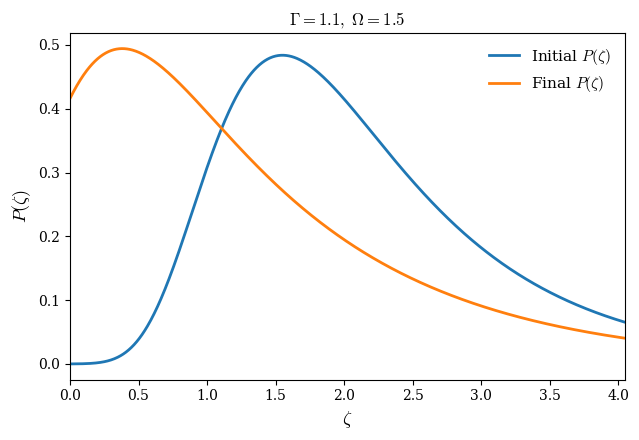

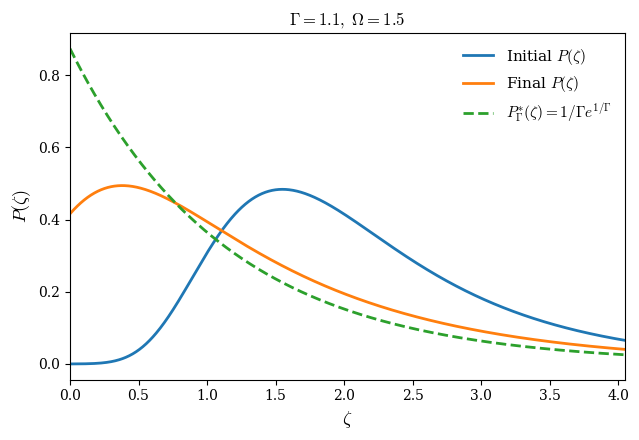

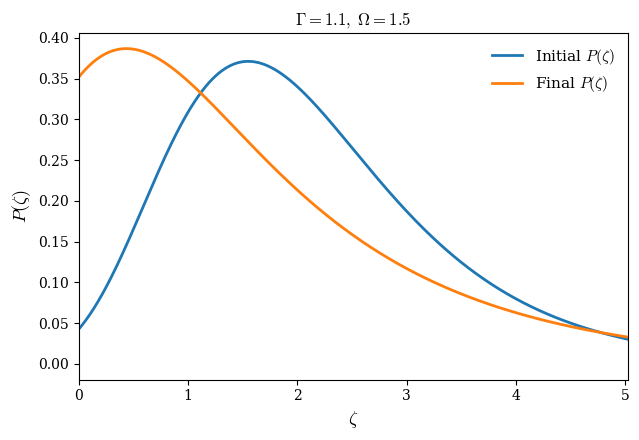

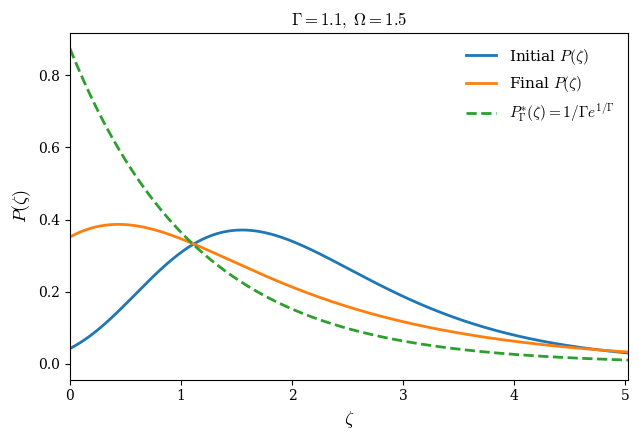

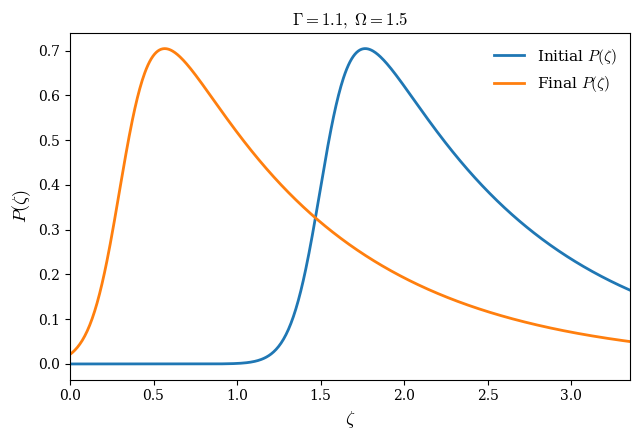

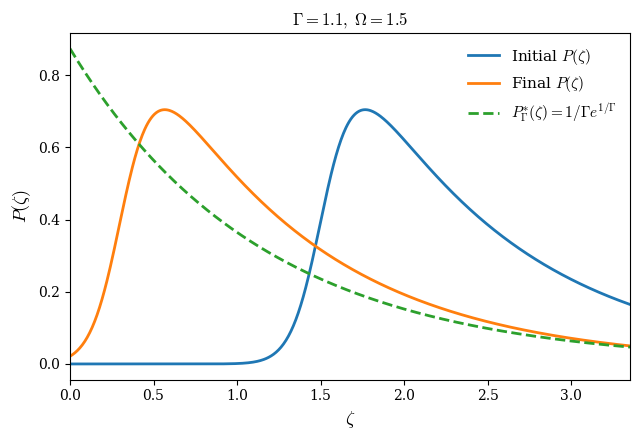

In [38]:
# ============================================
#  Evolution plots: separate figures per distribution
# ============================================

import matplotlib as mpl
mpl.rcParams["text.usetex"] = False

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif",
    "legend.frameon": False
})

Gamma_final = np.log(Omega0 / Omega_final)
n_steps = np.rint(Gamma_final / dGamma).astype(int)

for name, P_init_orig in initial_distributions_zeta.items():

    # ---------------------------------------------------------
    # Initial distribution
    # ---------------------------------------------------------
    P_init = P_init_orig.copy()
    P_init /= np.trapezoid(P_init, zeta)

    # ---------------------------------------------------------
    # Evolve to final step
    # ---------------------------------------------------------
    P_current = P_init.copy()
    for step in range(n_steps):
        P_current = evolve(P_current, zeta, dGamma)

    # ---------------------------------------------------------
    # Plot cutoff
    # ---------------------------------------------------------
    zeta_max_plot = intelligent_xmax(zeta, P_current, p=0.95)

    title_str = rf"$\Gamma = {Gamma_final:.1f},\ \Omega = {Omega_final:.1f}$"

    # =========================================================
    # Figure 1: initial + final
    # =========================================================
    fig1, ax1 = plt.subplots(figsize=(6.5, 4.5))

    ax1.plot(zeta, P_init, linewidth=2, label=r"Initial $P(\zeta)$")
    ax1.plot(
        zeta, P_current,
        linewidth=2,
        label=r"Final $P(\zeta)$"
    )

    ax1.set_xlim(0, zeta_max_plot)
    ax1.set_xlabel(r"$\zeta$", fontsize=13)
    ax1.set_ylabel(r"$P(\zeta)$", fontsize=13)
    ax1.set_title(title_str)
    ax1.legend(loc="upper right", fontsize=11)
    ax1.grid(False)

    plt.tight_layout()
    plt.savefig("presentation_figures/zeta_flow_1.pdf", bbox_inches="tight")

    # =========================================================
    # Figure 2: initial + final + exponential solution
    # =========================================================
    fig2, ax2 = plt.subplots(figsize=(6.5, 4.5))

    ax2.plot(zeta, P_init, linewidth=2, label=r"Initial $P(\zeta)$")
    ax2.plot(
        zeta, P_current,
        linewidth=2,
        label=r"Final $P(\zeta)$"
    )
    ax2.plot(
        zeta,
        exponential_pdf(zeta, Gamma_final),
        linewidth=2,
        linestyle="--",
        label="$P^{*}_{\Gamma}(\zeta) =1/\Gamma e^{1/\Gamma}$"
    )

    ax2.set_xlim(0, zeta_max_plot)
    ax2.set_xlabel(r"$\zeta$", fontsize=13)
    ax2.set_ylabel(r"$P(\zeta)$", fontsize=13)
    ax2.set_title(title_str)
    ax2.legend(loc="upper right", fontsize=11)
    ax2.grid(False)

    plt.tight_layout()
    plt.savefig("presentation_figures/zeta_flow_2.pdf", bbox_inches="tight")


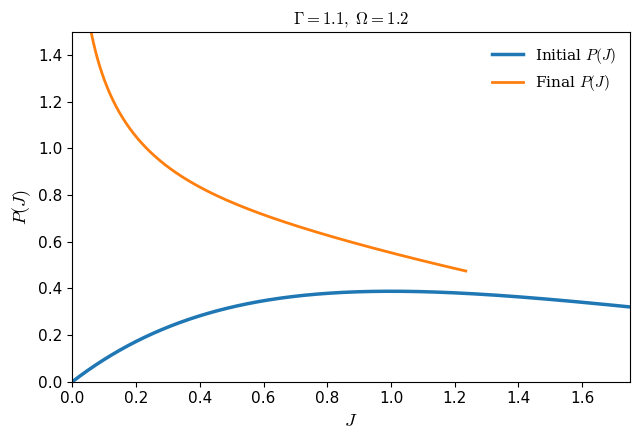

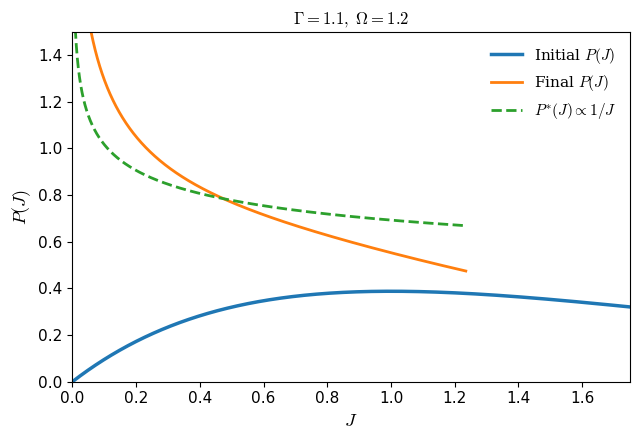

In [39]:
# ============================================
#  J–space evolution plots (two figures)
# ============================================

import matplotlib as mpl
mpl.rcParams["text.usetex"] = False

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif",
    "legend.frameon": False
})

# ---------------------------------------------------------
# Original PDF in J-space
# ---------------------------------------------------------
pJ_orig = initial_distributions_J[initial_distribution_name](J)
pJ_orig /= np.trapezoid(pJ_orig, J)

# ---------------------------------------------------------
# RG evolution in ζ-space
# ---------------------------------------------------------
pZ = initial_distributions_zeta[initial_distribution_name].copy()

Gamma_final = np.log(Omega0 / Omega_final)
n_steps = np.rint(Gamma_final / dGamma).astype(int)

Omega = Omega0
Gamma = 0.0

for _ in range(n_steps):
    pZ = evolve(pZ, zeta, dGamma)
    Omega *= (1 - dGamma)
    Gamma += dGamma

pZ_final = pZ

# ---------------------------------------------------------
# Convert final ζ → J
# ---------------------------------------------------------
J_vals, pJ_final = zeta_to_J_pdf_stable(
    pZ_final, zeta, Omega, N_J=2000
)

# Exponential fixed point mapped to J
J_vals, pJ_exp = zeta_to_J_pdf_stable(
    exponential_pdf(zeta, Gamma), zeta, Omega
)

title_str = rf"$\Gamma = {Gamma_final:.1f},\ \Omega = {Omega:.1f}$"

# =========================================================
# Figure 1: original + final (NO fixed-point solution)
# =========================================================
fig1, ax1 = plt.subplots(figsize=(6.5, 4.5))

ax1.plot(
    J, pJ_orig,
    linewidth=2.5,
    label=r"Initial $P(J)$"
)

ax1.plot(
    J_vals, pJ_final,
    linewidth=2,
    label=r"Final $P(J)$"
)

ax1.set_xlim(0, 1.75)
ax1.set_ylim(0, 1.5)
ax1.set_xlabel(r"$J$", fontsize=13)
ax1.set_ylabel(r"$P(J)$", fontsize=13)
ax1.set_title(title_str)
ax1.legend(loc="upper right", fontsize=11)
ax1.grid(False)

ax1.tick_params(axis="both", labelsize=11)
for lbl in ax1.get_xticklabels() + ax1.get_yticklabels():
    lbl.set_fontfamily("sans-serif")

plt.tight_layout()
plt.savefig("presentation_figures/J_flow_1.pdf", bbox_inches="tight")
plt.show()

# =========================================================
# Figure 2: original + final + 1/J fixed point
# =========================================================
fig2, ax2 = plt.subplots(figsize=(6.5, 4.5))

ax2.plot(
    J, pJ_orig,
    linewidth=2.5,
    label=r"Initial $P(J)$"
)

ax2.plot(
    J_vals, pJ_final,
    linewidth=2,
    label=r"Final $P(J)$"
)

ax2.plot(
    J_vals,
    real_power_law(J_vals, Omega, Gamma),
    linewidth=2,
    linestyle="--",
    label=r"$P^{*}(J)\propto 1/J$"
)


ax2.set_xlim(0, 1.75)
ax2.set_ylim(0, 1.5)
ax2.set_xlabel(r"$J$", fontsize=13)
ax2.set_ylabel(r"$P(J)$", fontsize=13)
ax2.set_title(title_str)
ax2.legend(loc="upper right", fontsize=11)
ax2.grid(False)

ax2.tick_params(axis="both", labelsize=11)
for lbl in ax2.get_xticklabels() + ax2.get_yticklabels():
    lbl.set_fontfamily("sans-serif")

plt.tight_layout()
plt.savefig("presentation_figures/J_flow_2.pdf", bbox_inches="tight")
plt.show()


In [40]:
# ============================================
#  Plot only the initial distribution in zeta space
# ============================================

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif",
    "legend.frameon": False
})

for name, P_init_orig in initial_distributions_zeta.items():

    # ---------------------------------------------------------
    # Initial distribution (normalized)
    # ---------------------------------------------------------
    P_init = P_init_orig.copy()
    P_init /= np.trapezoid(P_init, zeta)

    # ---------------------------------------------------------
    # Determine cutoff for plotting
    # ---------------------------------------------------------
    zeta_max_plot = intelligent_xmax(zeta, P_init, p=0.999)

    # =========================================================
    # Figure: initial distribution only
    # =========================================================
    fig, ax = plt.subplots(figsize=(6.5, 4.5))

    ax.plot(zeta, P_init, linewidth=2, label=r"Initial $P(\zeta)$")

    ax.set_xlim(0, zeta_max_plot)
    ax.set_xlabel(r"$\zeta$", fontsize=13)
    ax.set_ylabel(r"$P(\zeta)$", fontsize=13)
    ax.grid(False)

    plt.tight_layout()
    plt.savefig(f"presentation_figures/{name}_initial_distribution_zeta.pdf", bbox_inches="tight")
    plt.close(fig)


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/4113759919.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_init /= np.trapz(P_init, J)
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/4113759919.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_init /= np.trapz(P_init, J)


4.707529874575031
3.6234831569987827


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/4113759919.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_init /= np.trapz(P_init, J)
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/4113759919.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  P_init /= np.trapz(P_init, J)


4.673277651829047
1.569323235308886


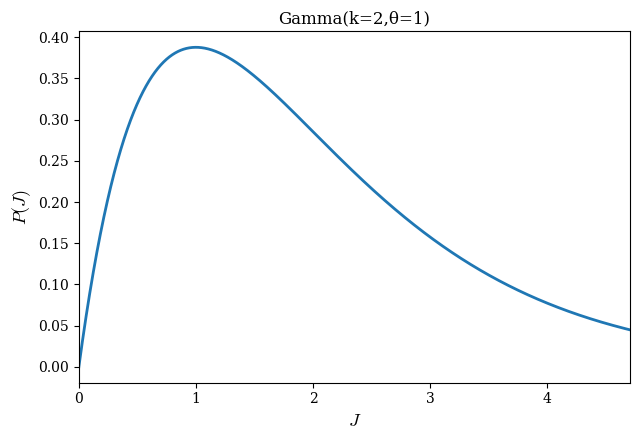

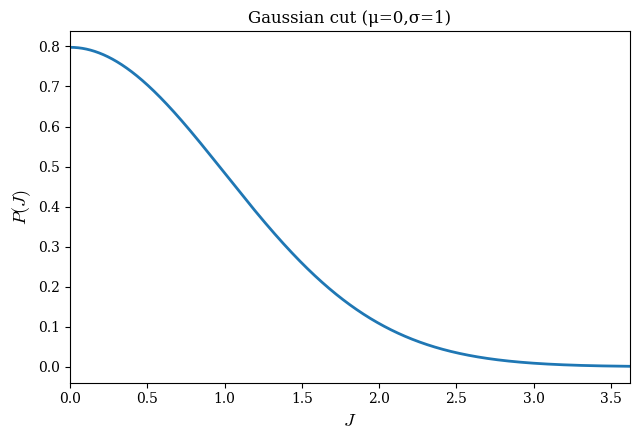

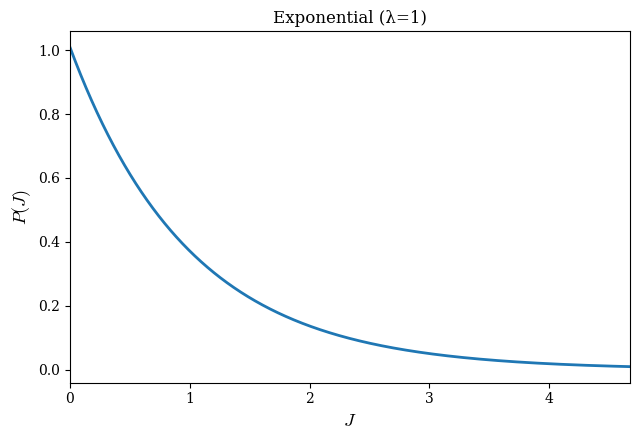

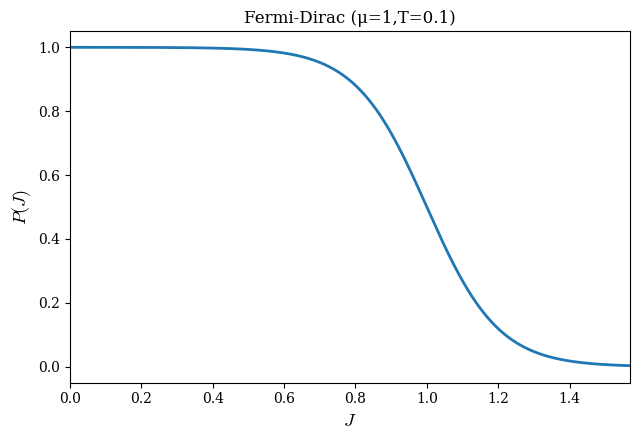

In [41]:
# Plot
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "mathtext.rm": "serif",
    "legend.frameon": False
})

for name, P_func in initial_distributions_J.items():
    # Evaluate function on grid
    P_init = P_func(J)
    
    # Normalize
    P_init /= np.trapz(P_init, J)
    J_max_plot = intelligent_xmax(J, P_init, p=0.9999)
    print(J_max_plot)
    # Plot
    plt.figure(figsize=(6.5, 4.5))
    plt.xlim(0, J_max_plot)
    plt.plot(J, P_init, linewidth=2, label=r"Initial $P(J)$")
    plt.xlabel(r"$J$", fontsize=13)
    plt.ylabel(r"$P(J)$", fontsize=13)
    plt.title(name)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"presentation_figures/{name}_initial_distribution_J.pdf", bbox_inches="tight")


In [53]:
# =====================================================
# Precompute RG flow in ζ-space
# =====================================================

n_frames = 100

Pz_history = {name: [] for name in names}

# initialize
Pz_current = {}
for name in names:
    P0 = initial_distributions_zeta[name].copy()
    P0 /= np.trapezoid(P0, zeta)
    Pz_current[name] = P0
    Pz_history[name].append(P0.copy())

# evolve
for frame in range(1, n_frames):
    for name in names:
        Pz_current[name] = evolve(Pz_current[name], zeta, dGamma)
        Pz_history[name].append(Pz_current[name].copy())


In [59]:
# =====================================================
#  RG flow animations in ζ and J space
#  (consistent with real_RG_flow.ipynb)
# =====================================================

from matplotlib.animation import FuncAnimation, PillowWriter

# -----------------------------------------------------
# Animation parameters
# -----------------------------------------------------
fps = 10

# -----------------------------------------------------
# Prepare initial ζ distributions
# -----------------------------------------------------
names = list(initial_distributions_zeta.keys())

Pz_list = []
Pz_init = []

for name in names:
    P0 = initial_distributions_zeta[name].copy()
    P0 /= np.trapezoid(P0, zeta)
    Pz_list.append(P0.copy())
    Pz_init.append(P0.copy())

# -----------------------------------------------------
# Storage for moments
# -----------------------------------------------------
Gamma_vals = np.arange(n_frames) * dGamma

mean_zeta = {name: [] for name in names}
median_zeta = {name: [] for name in names}

mean_J = {name: [] for name in names}
median_J = {name: [] for name in names}

# =====================================================
# 1) ζ-space animation
# =====================================================
fig_zeta, axes_zeta = plt.subplots(2, 2, figsize=(14, 10))
axes_zeta = axes_zeta.flatten()

lines_zeta = []
titles_zeta = []

for ax, name, P0 in zip(axes_zeta, names, Pz_init):
    l_init, = ax.plot(zeta, P0, lw=1.5, label="Initial")
    l_evol, = ax.plot(zeta, P0, lw=2, label=r"$P(\zeta,\Gamma)$")
    l_fp,   = ax.plot(
        zeta,
        exponential_pdf(zeta, dGamma),
        lw=2, ls="--", label="Fixed point"
    )

    ax.legend(fontsize=8)
    ax.set_xlim(0, intelligent_xmax(zeta, P0, 0.99))
    ax.set_ylim(0, 1.1 * P0.max())
    ax.set_xlabel(r"$\zeta$", fontsize=13)
    ax.set_ylabel(r"$P(\zeta)$", fontsize=13)

    titles_zeta.append(ax.set_title(f"{name} — Γ = 0"))

    # THIS LINE IS CRUCIAL
    lines_zeta.append((l_evol, l_fp))


plt.tight_layout()

def update_zeta(frame):
    Gamma = frame * dGamma

    for i, name in enumerate(names):
        Pz = Pz_history[name][frame]

        lines_zeta[i][0].set_ydata(Pz)
        lines_zeta[i][1].set_ydata(
            exponential_pdf(zeta, Gamma if Gamma > 0 else dGamma)
        )

        xmax = intelligent_xmax(zeta, Pz, 0.99)
        axes_zeta[i].set_xlim(0, xmax)
        titles_zeta[i].set_text(f"{name} — Γ = {Gamma:.2f}")

    return [l for pair in lines_zeta for l in pair]

for i, pair in enumerate(lines_zeta):
    assert len(pair) == 2, f"Panel {i} has wrong number of lines"



ani_zeta = FuncAnimation(fig_zeta, update_zeta,
                         frames=n_frames, interval=100)

ani_zeta.save("rg_flow_zeta.gif",
              writer=PillowWriter(fps=fps))

plt.close(fig_zeta)

# =====================================================
# 2) J-space animation (ζ → J at each step)
# =====================================================
fig_J, axes_J = plt.subplots(2, 2, figsize=(14, 10))
axes_J = axes_J.flatten()

lines_J = []
titles_J = []

for ax, name, Pz0 in zip(axes_J, names, Pz_init):
    J_vals, PJ0 = zeta_to_J_pdf_stable(Pz0, zeta, Omega0)

    l_init, = ax.plot(J_vals, PJ0, lw=1.5, label="Initial")
    l_evol, = ax.plot(J_vals, PJ0, lw=2, label=r"$P(J,\Gamma)$")
    l_fp,   = ax.plot(J_vals, PJ0, lw=2, ls="--", label="Fixed point")

    ax.legend(fontsize=8)
    ax.set_xlim(J_vals.min(), J_vals.max())
    ax.set_ylim(0, 10 * PJ0.max())
    ax.set_xlabel(r"$J$", fontsize=13)
    ax.set_ylabel(r"$P(J)$", fontsize=13)
    ax.set_xscale("log")
    ax.set_yscale("log")


    titles_J.append(ax.set_title(f"{name} — Γ = 0"))
    lines_J.append((l_evol, l_fp))

plt.tight_layout()

def update_J(frame):
    Gamma = frame * dGamma
    Omega = Omega0 * np.exp(-Gamma)

    for i, name in enumerate(names):
        # ζ → J mapping
        Pz = Pz_history[name][frame]
        J_vals, PJ = zeta_to_J_pdf_stable(Pz, zeta, Omega)

        # evolved distribution
        lines_J[i][0].set_ydata(PJ)

        # fixed-point distribution
        PJ_fp = real_power_law(J_vals, Omega, Gamma if Gamma > 0 else dGamma)
        lines_J[i][1].set_ydata(PJ_fp)

        # axes + title
        axes_J[i].set_xlim(J_vals.min(), Omega)
        axes_J[i].set_ylim(0, 1.1 * PJ.max())
        titles_J[i].set_text(
            f"{names[i]} — $\Omega = {Omega:.2f}$"
        )

    return [l for pair in lines_J for l in pair]



ani_J = FuncAnimation(fig_J, update_J,
                      frames=n_frames, interval=100)

ani_J.save("rg_flow_J.gif",
           writer=PillowWriter(fps=fps))

plt.close(fig_J)

print("Saved: rg_flow_zeta.gif and rg_flow_J.gif")


<>:150: SyntaxWarning: invalid escape sequence '\O'
<>:150: SyntaxWarning: invalid escape sequence '\O'
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/2870088401.py:150: SyntaxWarning: invalid escape sequence '\O'
  f"{names[i]} — $\Omega = {Omega:.2f}$"
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_54106/2870088401.py:148: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes_J[i].set_ylim(0, 1.1 * PJ.max())


Saved: rg_flow_zeta.gif and rg_flow_J.gif


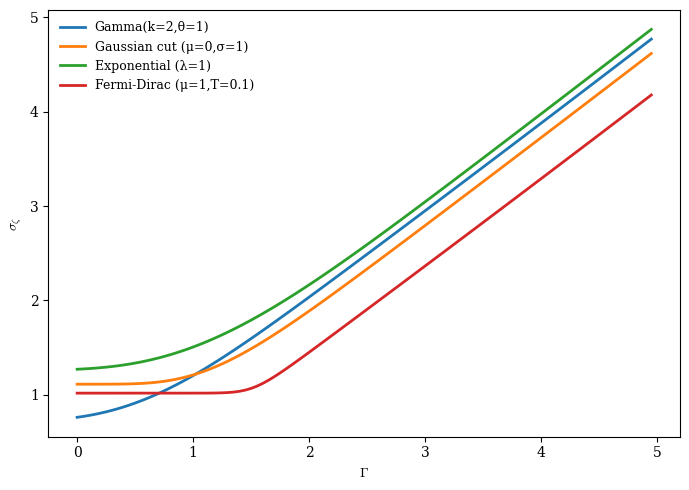

In [60]:
# =====================================================
#  σ(Γ) in ζ-space for all initial distributions
# =====================================================

fig_sigma, ax_sigma = plt.subplots(figsize=(7, 5))

for name in names:
    sigmas = []

    for frame in range(n_frames):
        Gamma = frame * dGamma
        Pz = Pz_history[name][frame]

        sigmas.append(sigma_P(zeta, Pz))

    ax_sigma.plot(
        Gamma_vals,
        sigmas,
        lw=2,
        label=name
    )

ax_sigma.set_xlabel(r"$\Gamma$")
ax_sigma.set_ylabel(r"$\sigma_\zeta$")
ax_sigma.legend(fontsize=9)
ax_sigma.grid(False)

plt.tight_layout()
plt.savefig("sigma_vs_Gamma_zeta.pdf", bbox_inches="tight")
plt.show()


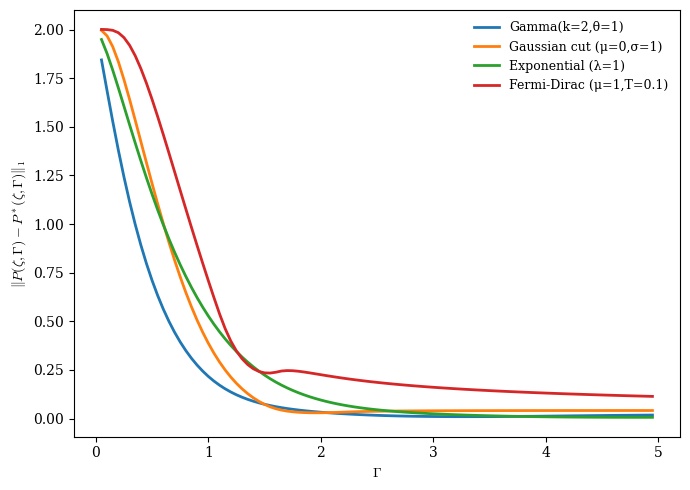

In [61]:
# =====================================================
#  L1 distance to fixed point in ζ-space
# =====================================================

fig_L1, ax_L1 = plt.subplots(figsize=(7, 5))

for name in names:
    L1_vals = []

    for frame in range(1, n_frames):  # skip Γ=0
        Gamma = frame * dGamma
        Pz = Pz_history[name][frame]

        P_fp = exponential_pdf(zeta, Gamma)
        L1_vals.append(L1_distance(Pz, P_fp, zeta))

    ax_L1.plot(
        Gamma_vals[1:],
        L1_vals,
        lw=2,
        label=name
    )

ax_L1.set_xlabel(r"$\Gamma$")
ax_L1.set_ylabel(r"$\|P(\zeta,\Gamma)-P^*(\zeta,\Gamma)\|_1$")
# ax_L1.set_yscale("log")
ax_L1.legend(fontsize=9)
ax_L1.grid(False)

plt.tight_layout()
plt.savefig("L1_distance_vs_Gamma_zeta.pdf", bbox_inches="tight")
plt.show()


In [62]:
# run this cell to convert the gif to a collection of images

from PIL import Image
import os

gif = Image.open("rg_flow_J.gif")
os.makedirs("rg_J_frames", exist_ok=True)

for i in range(gif.n_frames):
    gif.seek(i)
    gif.save(f"rg_J_frames/rg_flow_{i:03d}.png")


In [63]:
# run this cell to convert the gif to a collection of images

from PIL import Image
import os

gif = Image.open("rg_flow_zeta.gif")
os.makedirs("rg_zeta_frames", exist_ok=True)

for i in range(gif.n_frames):
    gif.seek(i)
    gif.save(f"rg_zeta_frames/rg_flow_{i:03d}.png")
